In [184]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

### data

In [231]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [233]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


### plot

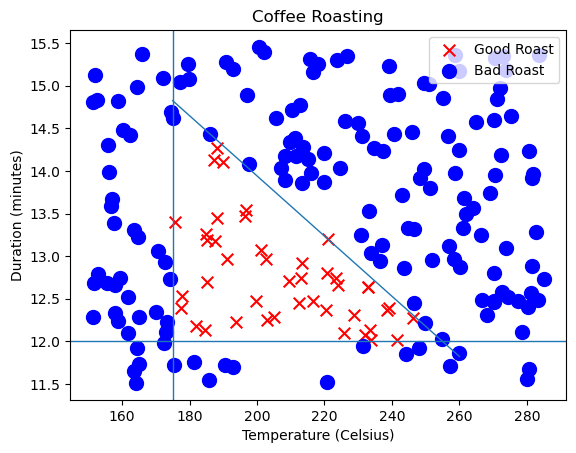

In [236]:
y = Y.reshape(-1,)
fig, ax = plt.subplots(1,1,)
ax.scatter(X[y==1,0],X[y==1,1], s=70, marker='x', c='red', label="Good Roast" )
ax.scatter(X[y==0,0],X[y==0,1], s=100, marker='o', facecolors='blue',linewidth=1,  label="Bad Roast")
tr = np.linspace(175,260,50)
ax.plot(tr, (-3/85) * tr + 21,linewidth=1)
ax.axhline(y=12,linewidth=1)
ax.axvline(x=175,linewidth=1)
ax.set_title(f"Coffee Roasting")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Duration (minutes)")
ax.legend(loc='upper right')
plt.show()

### normalization

In [238]:
print(f"Temperature Max, Min before normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min before normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)

print(f"Temperature Max, Min after normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min after normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min before normalization: 284.99, 151.32
Duration    Max, Min before normalization: 15.45, 11.51
Temperature Max, Min after normalization: 1.66, -1.69
Duration    Max, Min after normalization: 1.79, -1.70


In [240]:
# Tile/copy our data to increase the training set size and reduce the number of training epochs.
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)  

(200000, 2) (200000, 1)


## Tensorflow model

In [268]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),   # specifies the expected shape of the input
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [270]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [286]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-8.94  0.29 12.89]
 [-0.17 -7.34 10.79]] 
b1(3,): [-9.87 -9.28  1.01]
W2(3, 1):
 [[-31.38]
 [-27.86]
 [-32.79]] 
b2(1,): [15.54]


In [276]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

# epoche = 10 means the entire data set should be applied during training 10 times. 
# For efficiency, the training data set is broken into 'batches'. 
# The default size of a batch in Tensorflow is 32. 
#There are 200000 examples in our expanded data set or 6250 batches.
model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 606us/step - loss: 0.2975
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 769us/step - loss: 0.1320
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.1199
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 787us/step - loss: 0.0970
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 609us/step - loss: 0.0214
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 643us/step - loss: 0.0132
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 708us/step - loss: 0.0092
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 669us/step - loss: 0.0067
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 609us/step - loss: 0.0048
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 778us/step - loss: 0.0035


In [280]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[14.136469   12.479939    0.01745859]
 [11.835136    0.25049064 -8.817866  ]] 
b1: [  1.6738613  13.085846  -11.051764 ]
W2:
 [[-41.173546]
 [ 35.60505 ]
 [-41.78238 ]] 
b2: [-11.651828]


In [282]:
# Set weights from a previous run. 
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])

# Replace the weights from your trained model with
# the values above.
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])


In [284]:
# Check if the weights are successfully replaced
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-8.94  0.29 12.89]
 [-0.17 -7.34 10.79]] 
b1: [-9.87 -9.28  1.01]
W2:
 [[-31.38]
 [-27.86]
 [-32.79]] 
b2: [15.54]


### prediction

In [264]:
X_test = np.array([
    [200,13.9],  # positive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predictions = 
 [[9.625127e-01]
 [3.031606e-08]]


In [229]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]
